In [49]:
#!pip install --upgrade pandas plotly
#!pip install umap-learn
#!pip install pandas numpy fcsparser scikit-learn
#!pip install tensorflow keras
#!pip install matplotlib seaborn plotly
#!pip install pandas
#!pip install jupyterlab --upgrade
#jupyter labextension update jupyterlab-plotly

SyntaxError: invalid syntax (819353851.py, line 8)

# Import Libraries

In [1]:
#General Imports
import os
import pandas as pd
import numpy as np
import fcsparser
from collections import Counter

#Imports for MLP
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Input 

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go

#from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

#from umap import UMAP



# Import Monoculture Files

In [2]:
def load_and_sample_data(folder_path, species, sample_size=12000, files_to_process=None):
    columns_to_keep = [ 'FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A','PI-H', 'PI-A', 'FSC-Width'] #['FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A', 'PI-H', 'PI-A', 'FSC-Width']
    data_list = []
    processed_files = 0
    total_samples = 0  

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.fcs'):
            if files_to_process is not None and processed_files >= files_to_process:
                break
            filepath = os.path.join(folder_path, filename)
            meta, data = fcsparser.parse(filepath, meta_data_only=False, reformat_meta=True)
            data = data.loc[:, data.columns.intersection(columns_to_keep)]
            sampled_data = data.sample(n=min(sample_size, len(data)), random_state=1)
            sampled_data['label'] = species
            data_list.append(sampled_data)
            processed_files += 1
            total_samples += len(sampled_data)  
    combined_data = pd.concat(data_list)
    return combined_data, processed_files, total_samples

# File paths and number of fsc files to import
bacteroides_data, bacteroides_files, bacteroides_samples = load_and_sample_data("C:/Users/herme/Desktop/Live_Dead_Data/BT", 'bacteroides', files_to_process=None)
blautia_data, blautia_files, blautia_samples = load_and_sample_data('C:/Users/herme/Desktop/Live_Dead_Data/BH', 'blautia', files_to_process=None)
blanks_data, blanks_files, blanks_samples = load_and_sample_data('C:/Users/herme/Desktop/Live_Dead_Data/Blanks', 'blank', files_to_process=12)

all_data = pd.concat([bacteroides_data, blautia_data, blanks_data])


In [12]:
#print(all_data)
#all_data.to_csv('monocultures.tsv', columns=['label'], sep='\t', index=False)

## Check the imported files counts 

In [3]:
# Display the counts for the imported files
print(f"Bacteroides: {bacteroides_files} files processed, {bacteroides_samples} samples")
print(f"Blautia: {blautia_files} files processed, {blautia_samples} samples")
print(f"Blanks: {blanks_files} files processed, {blanks_samples} samples")
total_files = bacteroides_files + blautia_files + blanks_files
total_samples = bacteroides_samples + blautia_samples + blanks_samples
print(f"Total: {total_files} files processed, {total_samples} samples")

label_counts = all_data['label'].value_counts()
print(label_counts)

Bacteroides: 8 files processed, 96000 samples
Blautia: 8 files processed, 96000 samples
Blanks: 10 files processed, 38520 samples
Total: 26 files processed, 230520 samples
label
bacteroides    96000
blautia        96000
blank          38520
Name: count, dtype: int64


###3D plot of the 3 channels in the alldataobject(contains the data from the blank and monocultures)
#Apply arcsinh transformation to numeric columns
all_data_numeric = all_data[['FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A','PerCP-H','PerCP-A','APC-H','APC-A','PI-H', 'PI-A', 'FSC-Width']]
all_data_transformed = np.arcsinh(all_data_numeric / 150)
#Reintegrate 'predictions' column from original data
all_data_transformed['label'] = all_data['label']
#Define colors based on labels
colors = {'bacteroides': 'red', 'blautia': 'blue', 'blank': 'green'}
#Create traces for each label
traces = []
for label, group in all_data_transformed.groupby('label'):
    trace = go.Scatter3d(
        x=group['FSC-A'],
        y=group['PI-A'],
        z=group['FITC-A'],
        mode='markers',
        marker=dict(
            color=colors[label],
            size=4,
            opacity=0.7
        ),
        name=label
    )
    traces.append(trace)
#Define layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Arcsinh(FSC-A/150)'),
        yaxis=dict(title='Arcsinh(PI-A)'),
        zaxis=dict(title='Arcsinh(FITC-A/150)')
    ),
    title='3D Plot of Data with Labels'
)
#Create figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.update_traces(marker=dict(size=1.1))  
fig.show()

## Check Distributions of monocultures and blanks

#bacteroides_data, blautia_data, and blanks_data 
datasets = {
    'Bacteroides': bacteroides_data,
    'Blautia': blautia_data,
    'Blanks': blanks_data
}

features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'lightgreen', 'salmon']  # Colors

for species_name, data in datasets.items():
    fig = go.Figure()
    
    for i, feature in enumerate(features_to_visualize):
        transformed_feature = np.arcsinh(data[feature] / 150)  
        # Add histogram for each feature with probability density
        fig.add_trace(go.Histogram(x=transformed_feature,
                                   name=f'{feature} (arcsinh transformed)',
                                   marker_color=colors[i],
                                   opacity=0.6,
                                   histnorm='probability density'))  
    
    # Update the layout for each species plot
    fig.update_layout(title_text=f'Distributions of Channels (arcsinh transformed) - {species_name}',
                      xaxis_title_text='Arcsinh Values',
                      yaxis_title_text='Probability Density',  
                      bargap=0.2,  # Space between bars
                      legend_title_text='Feature')
    
    # Show the plot
    fig.show()

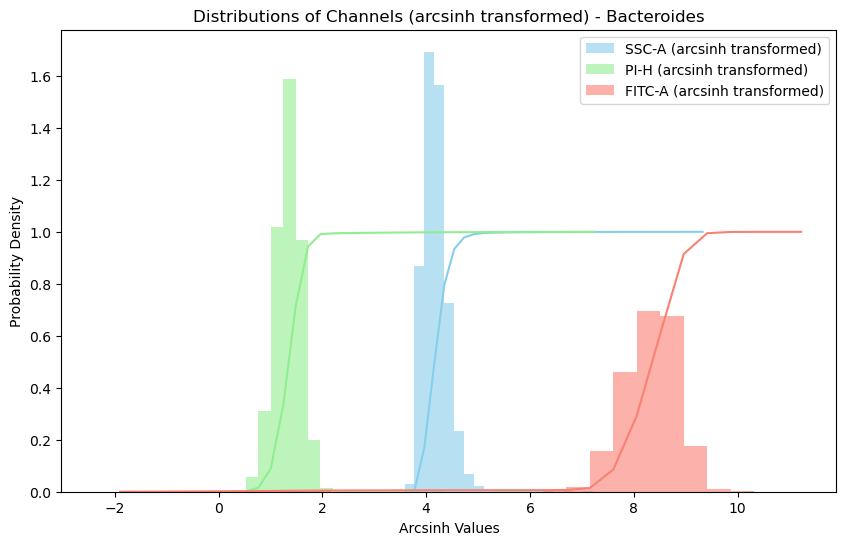

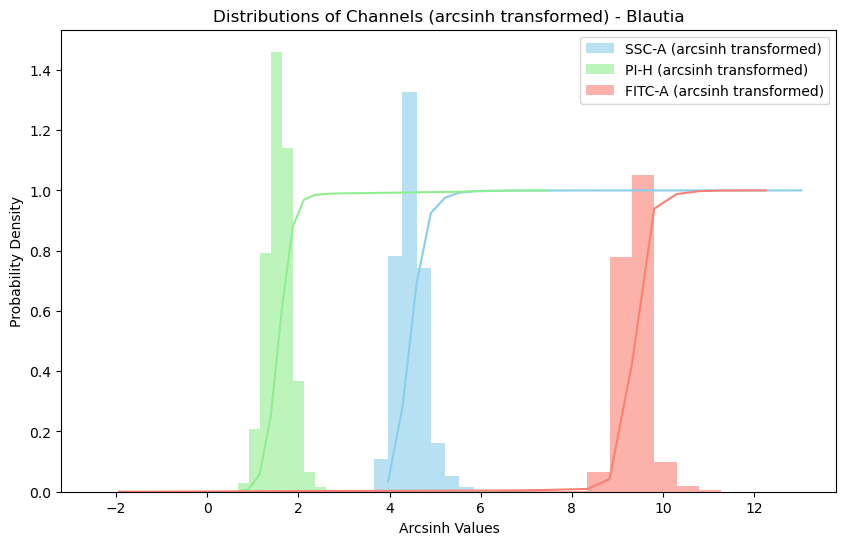

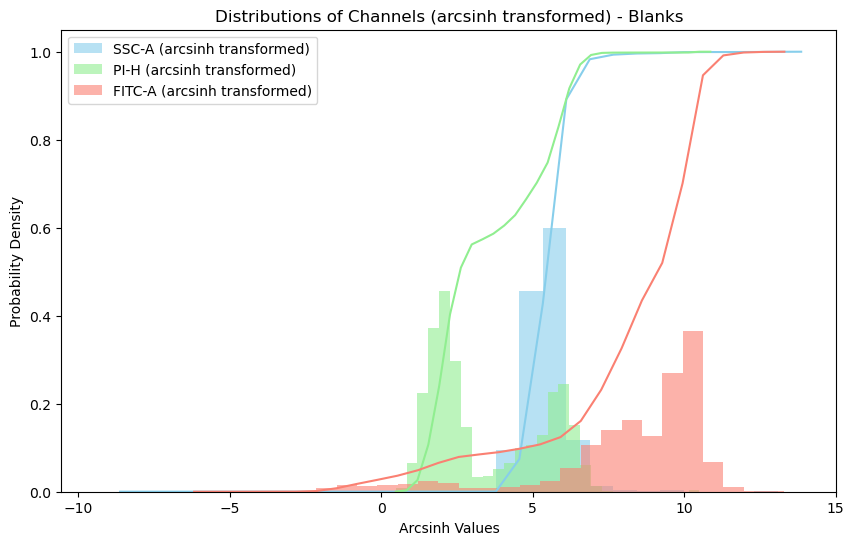

In [4]:
 datasets = {
     'Bacteroides': bacteroides_data,
     'Blautia': blautia_data,
     'Blanks': blanks_data
 }

features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'lightgreen', 'salmon']  # Colors

for species_name, data in datasets.items():
    plt.figure(figsize=(10, 6))  # Set the figure size
    
    # Plot histogram for each feature
    for i, feature in enumerate(features_to_visualize):
        transformed_feature = np.arcsinh(data[feature] / 150)
        
        # Calculate density
        density, bins, _ = plt.hist(transformed_feature, bins=30, color=colors[i], alpha=0.6, density=True, label=f'{feature} (arcsinh transformed)')
        count, _ = np.histogram(transformed_feature, bins)
        cum_density = np.cumsum(density * np.diff(bins))
        
        # Add a line plot for the cumulative density
        plt.plot(bins[1:], cum_density, color=colors[i])
    
    plt.title(f'Distributions of Channels (arcsinh transformed) - {species_name}')
    plt.xlabel('Arcsinh Values')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# Prepare the imported monoculture files for training

In [5]:
# PCA whitening transformation function ---------------------------------
#def whiten(X):
#    X_centered = X - np.mean(X, axis=0)
#    pca = PCA(whiten=True)
 #   X_whitened = pca.fit_transform(X_centered)
#    return X_whitened
#-----------------------------------------------------------------------

# Preparing the dataset for training (all the monoculture fsc)
X = all_data.drop('label', axis=1)

# Standard scaling (optional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply arcsinh transformation
X_arcsinh = np.arcsinh(X_scaled / 150)

#X_centered = X_arcsinh- np.mean(X_arcsinh, axis=0)
#pca = PCA(whiten=True)
#X_whitened = pca.fit_transform(X_centered)

# Initialize the LabelEncoder
le = LabelEncoder()

# Encod the labels
y = le.fit_transform(all_data['label'])
y_categorical = to_categorical(y)

# Splitting the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_arcsinh , y_categorical, test_size=0.2, random_state=42) #X_whitened instead of arcsinh



## Labels encoded

In [6]:
# Check what 0, 1, and 2 correspond to in the labels for the encoding:
labels_to_check = [0, 1, 2]
original_labels = le.inverse_transform(labels_to_check)

# Print the original string labels for 0, 1, and 2
print({encoded: label for encoded, label in zip(labels_to_check, original_labels)})

{0: 'bacteroides', 1: 'blank', 2: 'blautia'}


In [92]:
#Check label Encoding
#print(y)
#print(y_categorical )
#y_df=pd.DataFrame(y)
#y_cat_df=pd.DataFrame(y_categorical)
#y_df.to_csv('y.tsv', sep='\t', index=False)
#y_cat_df.to_csv('y_cate.tsv', sep='\t', index=False)

# To see the mapping from integer encoding back to original string labels:
#inverse_map = le.inverse_transform(y)

# Now, 'inverse_map' is a dictionary where keys are integer labels and values are the original strings
#print(inverse_map)

# Train the Neural Network(feedfowrward)-(2 hidden layers with relu and 1 output layer with softmax for classification) 

#Neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

#Save the trained model
model.save('trained_model.keras')  #  replace trained_model.keras with the desired file path.

In [7]:
# Neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape explicitly
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Save the trained model
model.save('trained_model.keras')  # Replace 'trained_model.keras' with your desired file path.If not trained model will be saved in the same folder as this notebook

Epoch 1/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7405 - loss: 0.6432 - val_accuracy: 0.8558 - val_loss: 0.3898
Epoch 2/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8539 - loss: 0.3776 - val_accuracy: 0.8635 - val_loss: 0.3575
Epoch 3/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8656 - loss: 0.3447 - val_accuracy: 0.8730 - val_loss: 0.3375
Epoch 4/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8719 - loss: 0.3259 - val_accuracy: 0.8736 - val_loss: 0.3245
Epoch 5/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8764 - loss: 0.3146 - val_accuracy: 0.8827 - val_loss: 0.3069
Epoch 6/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8799 - loss: 0.3063 - val_accuracy: 0.8839 - val_loss: 0.2995
Epoch 7/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8840 - loss: 0.2982 - val_accuracy: 0.8879 - val_loss: 0.2943
Epoch 8/50
5763/5763 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8910 - loss: 0.2851 - 

### Model Statistics

In [8]:
# Check what 0, 1, and 2 correspond to in the labels for the encoding:
labels_to_check = [0, 1, 2]
original_labels = le.inverse_transform(labels_to_check)

# Print the original string labels for 0, 1, and 2
print({encoded: label for encoded, label in zip(labels_to_check, original_labels)})

{0: 'bacteroides', 1: 'blank', 2: 'blautia'}


1441/1441 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.9460 - loss: 0.1562
Evaluation Metrics:
Loss: 0.15425211191177368
Accuracy: 0.9461435079574585
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18931
           1       0.92      0.90      0.91      7765
           2       0.92      0.96      0.94     19408

    accuracy                           0.95     46104
   macro avg       0.94      0.94      0.94     46104
weighted avg       0.95      0.95      0.95     46104



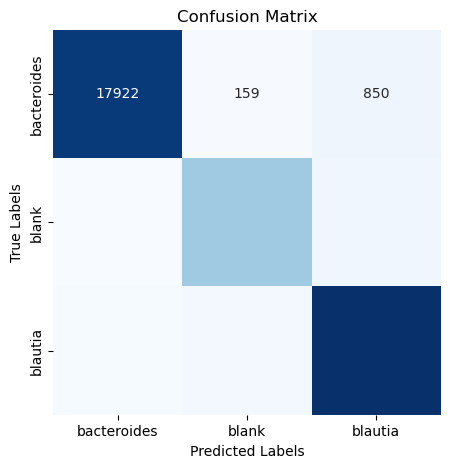

In [10]:
# Load the trained model
#model = load_model('trained_model.keras') 

# Evaluate the loaded model
evaluation = model.evaluate(X_val, y_val)

# Print evaluation metrics
print("Evaluation Metrics:")
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Create a list of labels based on the encoding mapping
class_labels = ['bacteroides', 'blank', 'blautia']                  #BASED ON THE ENCODING BEFORE

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix with labels
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
#  predicted classes(look for the necoding, in our case 0 is bacteroides,1 is blanks and 2 is blautia)
predicted_classes_distribution = Counter(y_pred_classes)
print(predicted_classes_distribution)

Counter({2: 20306, 0: 18161, 1: 7637})


# Import the Coculture cytometry file and predict the labels

In [12]:
#Function to rpedict and import ,nothing to do here
    
def predict_species(filepath, model, columns_to_keep):
    _, data = fcsparser.parse(filepath, reformat_meta=True)
    data_df = pd.DataFrame(data)[columns_to_keep]
    
    X_co_scaled=scaler.transform(data_df)
    # Apply arcsinh transformation
    data_df_arcsinh = np.arcsinh(X_co_scaled / 150)
    
    # Apply PCA whitening to the dataset
    #X_data_df_whitened = whiten(data_df_arcsinh)
      
    predictions = model.predict(data_df_arcsinh) #X_data_df_whitened
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes,data_df


## Choose path of the Coculture and Predict

In [13]:
for class_label, encoded_label in zip(le.classes_, range(len(le.classes_))):
    print(f"{class_label}: {encoded_label}")

bacteroides: 0
blank: 1
blautia: 2


In [14]:
# Define the columns to keep
columns_to_keep = [ 'FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A','PI-H', 'PI-A', 'FSC-Width']

# Import the Coculture path here
coculture_filepath = 'C:/Users/herme/Desktop/Live_Dead_Data/BHBT/05-t60_d100_wc_bhbtD-F5.fcs'#here is the path to fsc

C,data_df = predict_species(coculture_filepath, model, columns_to_keep)

# fcsparser to load the coculture data and keep only chosen columns
#_, coculture_raw_data = fcsparser.parse(coculture_filepath, reformat_meta=True)
#coculture_data = pd.DataFrame(coculture_raw_data)[columns_to_keep]

# Mapping prediction indices back to species names
index_to_species = {0: 'bacteroides', 1: 'blank', 2: 'blautia'} 
mapped_predictions = np.vectorize(index_to_species.get)(C)

# Adding predictions to the coculture data 
#coculture_data['predictions'] = mapped_predictions
data_df['predictions'] = mapped_predictions

4950/4950 ━━━━━━━━━━━━━━━━━━━━ 4s 900us/step


## Distributions coculture

features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'lightgreen', 'salmon']  # Colors for each distribution

fig = go.Figure()

for i, feature in enumerate(features_to_visualize):
    transformed_feature = np.arcsinh(data_df[feature] / 150)  
    # Add histogram for each feature
    fig.add_trace(go.Histogram(x=transformed_feature,
                               name=f'{feature} (arcsinh transformed)',
                               marker_color=colors[i],
                               opacity=0.6,
                               histnorm='probability density'))


fig.update_layout(title_text='Distributions of Channels (arcsinh transformed)',
                  xaxis_title_text='Arcsinh Values',
                  yaxis_title_text='Probability_Density',
                  legend_title_text='Feature'
                  ) 

fig.show()

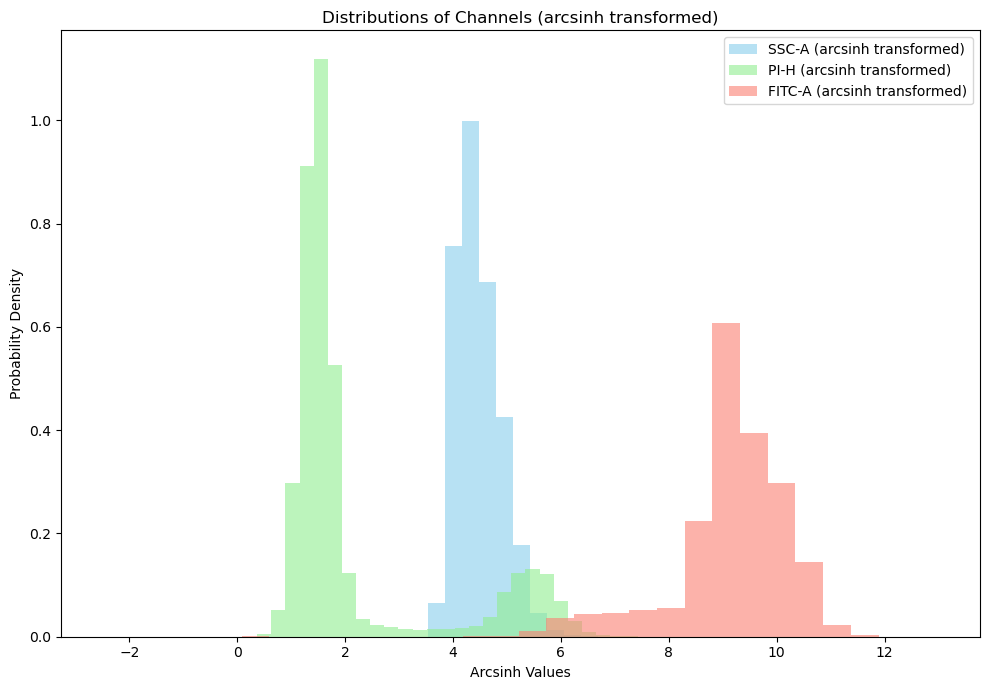

In [15]:
features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'lightgreen', 'salmon']  # Colors for each distribution

# Create a figure and axis
plt.figure(figsize=(10, 7))

# Loop through each feature to create a histogram
for i, feature in enumerate(features_to_visualize):
    # Apply arcsinh transformation
    transformed_feature = np.arcsinh(data_df[feature] / 150)
    
    # Plot histogram for each transformed feature
    plt.hist(transformed_feature, bins=30, color=colors[i], alpha=0.6, density=True, label=f'{feature} (arcsinh transformed)')

# Update the layout
plt.title('Distributions of Channels (arcsinh transformed)')
plt.xlabel('Arcsinh Values')
plt.ylabel('Probability Density')
plt.legend()  # Show the legend

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

## Count and Check Predictions

In [16]:
# Print the first five rows of coculture
print(data_df.tail())


               FSC-H         FSC-A         SSC-H        SSC-A        FITC-H  \
158371  16913.599609   7922.200195   9714.200195  8782.700195  1.808254e+06   
158372   7120.799805   7405.600098   5594.299805  4696.700195  6.004592e+05   
158373  21895.599609  12036.900391  10129.500000  9347.599609  3.437270e+06   
158374   8673.799805   6262.100098   4392.500000  5024.600098  7.391174e+05   
158375  14459.900391   8668.299805   7700.500000  6694.500000  1.729408e+06   

             FITC-A        PI-H        PI-A    FSC-Width  predictions  
158371  1651030.625  349.299988  428.700012   479.666992      blautia  
158372   531102.625  411.000000  314.200012  1065.060669      blautia  
158373  3107121.750  409.299988  134.899994   563.087708        blank  
158374   837064.875  336.100006  266.600006   739.424377  bacteroides  
158375  1562089.875  296.899994  110.300003   613.967896      blautia  


In [17]:
# Prediction Counts
prediction_counts = data_df['predictions'].value_counts()
print("Prediction Counts:")
print(prediction_counts)

Prediction Counts:
predictions
blautia        83499
bacteroides    43848
blank          31029
Name: count, dtype: int64


# Visualization

In [18]:
# Apply arcsinh transformation to numeric columns

coculture_data_numeric = data_df[[  'FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A','PI-H', 'PI-A', 'FSC-Width']]
coculture_data_arcsin = np.arcsinh(coculture_data_numeric / 150)

# Reintegrate 'predictions' column from original data
coculture_data_arcsin['predictions'] = data_df['predictions']

# Initialize LabelEncoder and encode the 'predictions' column
#label_encoder = LabelEncoder()
#coculture_data_arcsin['predictions_encoded'] = label_encoder.fit_transform(coculture_data_arcsin['predictions'])

# colors for each prediction label
color_map = {
    'bacteroides': 'skyblue',  #  color for bacteroides
    'blautia': 'lime',       #  color for blautia
    'blank': 'gray'        # color for blank
}

# Create the 3D scatter plot using Plotly
fig = px.scatter_3d(coculture_data_arcsin, x='SSC-A', y='FITC-A', z='PI-A', 
                    color='predictions',  
                    color_discrete_map=color_map,  
                    title="Coculture Predictions", 
                    labels={'SSC-A': 'SSC-A', 
                            'FITC-A': 'FITC-A Fluorescence', 
                            'PI-H': 'PI-A Fluorescence', 
                            'predictions': 'Predictions'})

# Adjust the layout to increase the size of the plot
fig.update_layout(width=800, height=800)
fig.update_traces(marker=dict(size=1.1))  
#fig.show()
fig.write_html('coculture_predictions_labels.html')

#Visualization
#coculture_data_numeric = data_df[[ 'FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A','PI-H', 'PI-A', 'FSC-Width']] 
#coculture_data_arcsin = np.arcsinh(coculture_data_numeric / 150) 

#Initialize LabelEncoder
#label_encoder = LabelEncoder()

#coculture_data_arcsin['predictions'] = data_df['predictions']  
#coculture_data_arcsin['predictions_encoded'] = label_encoder.fit_transform(coculture_data_arcsin['predictions']) 

#Create the 3D scatter plot
#fig = px.scatter_3d(coculture_data_arcsin, x='FSC-A', y='FITC-A', z='PI-A', color='predictions_encoded', 
                     #title="Coculture Predictions", 
                     #labels={'FSC-A': 'Forward Scatter', 'FITC-A': 'FITC-A Fluorescence', 'PI-A': 'PI-A Fluorescence', 'predictions_encoded': 'Predictions'},                 
#)
#fig.update_layout(width=800, height=600)
#fig.update_traces(marker=dict(size=1.1))  
#fig.write_html('coculture_predictions_labelencoder.html')
#fig.show()


# Gating

In [19]:
def apply_gating(data_df, pi_threshold, sybr_threshold):
    # Copy the DataFrame as to not change the original data 
    gated_data_df = data_df.copy()
    
    # applying arcsinh transformation with a cofactor
    cofactor = 150  # Cofactor for arcsinh transformation

    # Apply arcsinh transformation to numerical columns only
    for column in gated_data_df.select_dtypes(include=[np.number]).columns:
        gated_data_df[column] = np.arcsinh(gated_data_df[column] / cofactor)
    
    # Initialize the 'state' column with 'live' assuming most cells are live
    gated_data_df['state'] = 'live'
    
    # Identify inactive cells based on PI threshold
    gated_data_df.loc[gated_data_df['PI-A'] > pi_threshold, 'state'] = 'inactive'
    
    # Identify debris based on SYBR green (FITC-A) threshold among the remaining 'live' cells
    gated_data_df.loc[(gated_data_df['state'] == 'live') & (gated_data_df['FITC-A'] < sybr_threshold), 'state'] = 'debris'
    
    return gated_data_df

# Define your PI and SYBR green thresholds
pi_threshold = 2                  # Define your PI threshold value here
sybr_threshold = 7                # Define your SYBR green threshold value here

# Apply gating to the data
gated_data_df = apply_gating(data_df, pi_threshold, sybr_threshold)

In [85]:
#print(gated_data_df)

### Counts after gating coculture and predictions

In [20]:
# Prediction Counts
state_counts = gated_data_df['state'].value_counts()
print("State Counts:")
print(state_counts)

State Counts:
state
live        123141
inactive     34883
debris         352
Name: count, dtype: int64


In [21]:
# Filter for each condition
bacteroides_counts = gated_data_df[gated_data_df['predictions'] == 'bacteroides']['state'].value_counts()
blautia_counts = gated_data_df[gated_data_df['predictions'] == 'blautia']['state'].value_counts()
blanks_counts = gated_data_df[gated_data_df['predictions'] == 'blank']['state'].value_counts()

# Print 
print("Bacteroides State Counts:")
print(bacteroides_counts)
print("\nBlautia State Counts:")
print(blautia_counts)
print("\nBlanks State Counts:")
print(blanks_counts)


Bacteroides State Counts:
state
live        42098
inactive     1727
debris         23
Name: count, dtype: int64

Blautia State Counts:
state
live        75748
inactive     7751
Name: count, dtype: int64

Blanks State Counts:
state
inactive    25405
live         5295
debris        329
Name: count, dtype: int64


###  3D plot with the gating classifications

In [26]:
# Create a 3D scatter plot
fig = go.Figure()

# applying arcsinh transformation with a cofactor
#cofactor = 150  # Cofactor for arcsinh transformation

# Apply arcsinh transformation to numerical columns only
#for column in gated_data_df.select_dtypes(include=[np.number]).columns:
   # gated_data_df[column] = np.arcsinh(gated_data_df[column] / cofactor)


#  unique states and predictions for color
states = gated_data_df['state'].unique()
predictions = gated_data_df['predictions'].unique()

# Color map 
state_colors = {'live': 'skyblue', 'inactive': 'firebrick', 'debris': 'darkslategrey'}
prediction_markers = {'bacteroides': 'circle', 'blank': 'square', 'blautia': 'diamond'}

# Plot each combination of state and prediction
for state in states:
    for prediction in predictions:
        df_filtered = gated_data_df[(gated_data_df['state'] == state) & (gated_data_df['predictions'] == prediction)]
        fig.add_trace(go.Scatter3d(
            x=df_filtered['SSC-A'],
            y=df_filtered['FITC-A'],
            z=df_filtered['PI-H'],
            mode='markers',
            marker=dict(
                size=1,
                symbol=prediction_markers[prediction],  #  markers for predictions
                color=state_colors[state],  #  color state
            ),
            name=f'{state} - {prediction}'
        ))

# layout 
fig.update_layout(
    title="3D Scatter Plot of Gated Data by State and Prediction",
    scene=dict(
        xaxis_title='SSC-A',
        yaxis_title='FITC-A',
        zaxis_title='PI-H'
    )
)
fig.update_layout(width=800, height=700)
fig.write_html('Gating_predictions_coculture.html')
#fig.show()